In [1]:
from tucan.canonicalization import (partition_molecule_by_attribute,
                                    refine_partitions,
                                    assign_canonical_labels,
                                    serialize_molecule,
                                    canonicalize_molecule)
from tucan.io import graph_from_file, permute_molecule
from tucan.visualization import print_molecule, draw_molecules
from pathlib import Path
from networkx.algorithms.components import is_connected
import networkx as nx
import random

def construct_filepath(name):
    return Path(f"../tests/molfiles/{name}/{name}.mol")

# Canonicalization

## Introduction
A molecule can be represented as a graph with atoms as nodes and bonds as edges.
To identify the nodes they are labeled with integers.
When two chemists draw the same molecule, they'll probably label the nodes differently (by drawing the nodes in different orders for instance), as illustrated with the example of water in `Figure 1`.

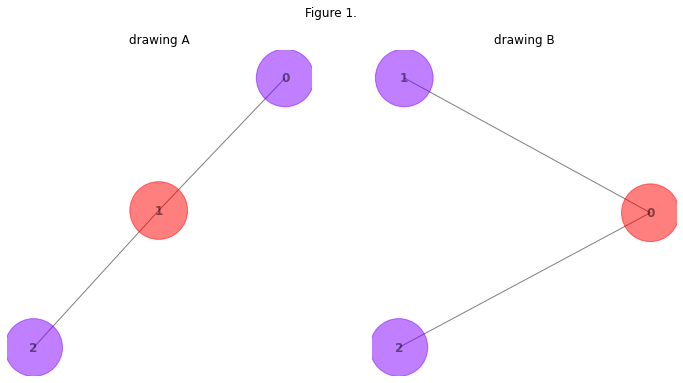

In [2]:
m = graph_from_file(construct_filepath("water"))
m_permuted = permute_molecule(m, random_seed=.42)
draw_molecules([m, m_permuted], ["drawing A", "drawing B"], highlight="atomic_number", title="Figure 1.")


If both molecules were saved in a database, we'd end up with duplicate molecules,
since the chemical structures are equivalent and merely differ in the labels (i.e, they are automorphic).
How do we know that the chemists are submitting the same molecule to the database?
This problem can be solved with canonicalization, that is, by assigning unique (canonical) node labels such that any two molecules that are isomorphic receive the same labeling.
According to [Reed & Corneil (1977)](https://sci-hub.ru/https://doi.org/10.1002/jgt.3190010410), "[t]wo [molecules M]1 and [M]2 are isomorphic if there exists a one-to-one mapping of the [nodes] of [M]1 onto the [nodes] of [M]2 such that adjacency is preserved,
i.e. two [nodes] in [M]1 are adjacent if and only if the corresponding [nodes] of [M]2 are adjacent."
However, the process of finding a canonical labeling can be computationally expensive as we'll show in the following.

A graph-labeling can be conceptualized as a string.
For example, we could order the node labels in `Figure 1, drawing A` by atomic number (first the purple hydrogen atoms, then the red oxygen atom) and string them together, resulting in the labeling `021`.
A _canonical_ labeling can be conceptualized as the [lexicographically](https://en.wikipedia.org/wiki/Lexicographic_order) minimal or maximal form of that string (let's use the minimal form for our example).
We can determine the canonical labeling by enumerating all possible strings that can be constructed from the three nodes, and choosing the minimal string (in this case, the first string).

| | hydrogen A | hydrogen B | oxygen |
|--|---|---|---|
|1.|0|1|2|
|2.|0|2|1|
|3.|1|0|2|
|4.|1|2|0|
|5.|2|0|1|
|6.|2|1|0|

The number of possible strings is $1*2*3=3!$, $N!$ in the general case. As $N$ grows larger, the number of labelings we need to enumerate with this brute-force approach grows rapidly. For a  modestly-sized molecule with ten nodes we need to enumerate $10!=3,628,800$ labelings.
Luckily, the computational costs of generating all $N!$ permutations of the node labels can be reduced by using invariants to partition the nodes into subsets.

## Molecule partitioning based on node-invariants
In the following, we use the term _invariant_ in the sense of _node-invariant_ (pertaining to a single node) as opposed to _graph-invariant_ (pertaining to the entire graph).
Invariants are node-properties that are independent of the labeling.
For instance, in `Figure 1`, the red oxygen atom, irrespective of its label, will always have the atomic number 8, and will always be connected to two hydrogens.

We can use the atomic numbers to partition the water molecule into two subsets, one subset containing the two hydrogens (atomic number 1), and another subset containing the oxygen (atomic number 8).
As mentioned earlier, in our example we chose to sort the nodes by atomic number in order to obtain the canonical labeling.
Therefore, we already know in advance that the oxygen atom receives the label `2`.
All that's left to permute now are the labels of the two hydrogens.

| | hydrogen A | hydrogen B | oxygen |
|--|---|---|---|
|1.|0|1|2|
|2.|1|0|2|

By partitioning the nodes into $k$ subsets containing $n_k$ nodes, we reduce $N!$ permutations to $\prod_{i=1}^{k}n_i!$.

The nodes in a partition are equivalent w.r.t. to the invariants.
Note that this does not imply that nodes within the same partition are automorphic ([Ivanciuc, 2008](https://sci-hub.ru/10.1002/9783527618279.ch7a)).
Equivalence w.r.t. the invariants is necessary but not sufficient for automorphism.
An automorphism group (aka orbit) is a set of nodes that have a structurally equivalent position in the graph, in other words, the nodes are symmetry-equivalent.
For example, the two automorphism groups in the table above are the two hydrogens $\{0, 1\}$, and the oxygen $\{2\}$.
The nodes within those groups are structurally interchangeable (as soon as stereochemistry comes into play this might not be true anymore in many cases).

In order to make the canonicalization computationally as cheap as possible, we aim to partition the molecule such that each partition contains as few nodes as possible. To achieve this, we need invariants with strong discriminatory power. In the remainder of the notebook, we introduce our invariants and show how they partition the nodes of an exemplary molecule, before we eventually assign canonical labels to the partitioned nodes.

### Atomic number
The atomic number is a straightforward invariant that doesn't require additional computation.
However, in cases of pure substances such as sulfur, the atomic number has no discriminatory power: all nodes are allocated to the same partition.
In general, based on atomic number, we can obtain at most as many partitions as there are different elements in a chemical structure.
### Fundamental cycles
Fundamental cycles are a generalization of [chordless cycles](https://en.wikipedia.org/wiki/Induced_path), such that the chord can contain more than one edge.
For the detection of fundamental cycles, we implemented a variation of the algorithm that has been proposed by [Gashler & Martinez (2012)](https://sci-hub.ru/10.1080/09540091.2012.664122) in their Figure 6.
Note that what Gashler and Martinez refer to as _atomic cycle_, we call _fundamental cycle_.
In doing so, we hope to avoid ambiguity arising from the chemical connotation of the term _atomic_.
Importantly, fundamental cycles are not equivalent to chemical rings.
While each fundamental cycle is a chemical ring, not every chemical ring is a fundamental cycle. 
In order to obtain an invariant from the fundamental cycles, we associate each node $i$ with all fundamental cycles that contain $i$.

TODO: Show example.

Each fundamental cycle is identified with an integer label, which is not meant to imply that these labels are ordinal, one cycle does not have precedence over the other.
The labels are merely meant to distinguish the fundamental cycles from each other.
We could use city names but integer labels are more convenient.
Strictly speaking, fundamental cycles are not invariants, since the cycle labels depend on the node labels.
Fundamental cycles split automorphism groups.
For example, the ring atoms in bicyclohexane (TODO: show) would be automorphic without the fundamental cycle invariant.
TODO: What are the implications of this for correctness of canonicalization (make question more precise)?

### Invariant-code
Based on the atomic number and the fundamental cycles, we generate an invariant-code for each node:

`<atomic number>-<comma-separated list of fundamental cycles>`.

Consider for example the invariant-code of the node with label `16` in `Table 1` below:

`6-2,1,0`

The leading `6` indicates that the node represents a carbon atom.
Further, we can infer that it's part of two fundamental cycles: `2` and `1`.
Note that all nodes carry a trailing `0` in their invariant-codes.
The `0`s are placeholders in case a node does not belong to a fundamental cycle.
The invariant-code partitions the molecule into five subsets (partition `0` through `3`), as is evident from `Table 1` and `Figure 2` below.

Table 1. Bicyclo[5.1.0]octa-1(7)-ene-8-one partitioned by invariant-code.
label    invariant-code    partition    neighbors (label, invariant-code, partition)
-------  ----------------  -----------  ----------------------------------------------
0        1                 0            (13, 6, 1)
1        1                 0            (11, 6, 1)
2        1                 0            (10, 6, 1)
3        1                 0            (11, 6, 1)
4        1                 0            (14, 6, 1)
5        1                 0            (14, 6, 1)
6        1                 0            (12, 6, 1)
7        1                 0            (13, 6, 1)
8        1                 0            (10, 6, 1)
9        1                 0            (12, 6, 1)
10       6                 1            (15, 6, 1), (14, 6, 1), (2, 1, 0), (8, 1, 0)
11       6                 1            (14, 6, 1), (13, 6, 1), (1, 1, 0), (3, 1, 0)
12       6                 1            (13, 6, 1), (16, 6, 1), (6, 1, 0),

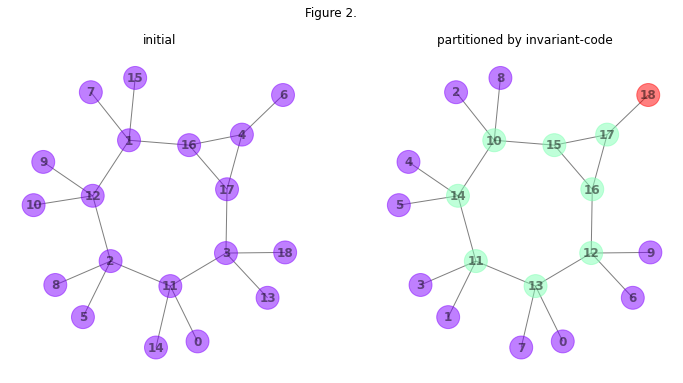

In [3]:
molecule = "Bicyclo[5.1.0]octa-1(7)-ene-8-one"
m = permute_molecule(graph_from_file(construct_filepath(molecule)), random_seed=.41)
m_partitioned_by_invariants = partition_molecule_by_attribute(m, "invariant_code", include_neighbors=False)
print_molecule(m_partitioned_by_invariants, f"Table 1. {molecule.capitalize()} partitioned by invariant-code.")
draw_molecules([m, m_partitioned_by_invariants], ["initial", "partitioned by invariant-code"], highlight="partition", title="Figure 2.")

### Extended invariant-code
So far, we only considered invariants that pertain to a single node.
However, we can increase the discriminatory power of the local invariants by incorporating information about the direct neighbors of a node $i$, that is, all neighboring nodes that are connected to $i$ by a single edge.
For example, nodes `12` and `13` from partition `1` are each connected to four direct neighbors: two carbons, and two hydrogen, as indicated by the leading `6`s and `1`s of the neighbors' invariant-codes.

| label | invariant-code | partition | neighbors (label, invariant-code, partition) |
|---|---|---|---|
| 12 | 6-1,0 | 1 | (13, 6-1,0, 1), (10, 6-1,0, 1), (4, 1-0, 0), (5, 1-0, 0) |
| 13 | 6-1,0 | 1 | (16, 6-2,1,0, 3), (12, 6-1,0, 1), (2, 1-0, 0), (8, 1-0, 0) |

However, the neighboring carbon nodes with labels `13` and `16` split partition `1`, since node `16` is connected to the fundamental cycles `2` and `1`, whereas node `13` is only connected to fundamental cycle `1`.
That is, we can discriminate nodes `12` and `13` based on their neighbors' invariant-codes.
Similarly, if two nodes belong to the same partition but have a different _number_ of direct neighbors, we can split these nodes' partition based on the number of neighbors.
The extended invariant-code adds two more invariants: the number of direct neighbors as well as the _configuration_ of neighbors.
By configuration we mean the tuple of the neighbors' invariant-codes (tuple in the sense of an ordered multiset). As can be seen below in `Table 2` and `Figure 3`, if we partition the molecule with the extended invariant-code we end up with a total of seven partitions, two more compared to the partitioning by local invariants.

Table 2. Bicyclo[5.1.0]octa-1(7)-ene-8-one partitioned by extended invariant-code.
label    invariant-code    partition    neighbors (label, invariant-code, partition)
-------  ----------------  -----------  ----------------------------------------------
0        1                 0            (13, 6, 1)
1        1                 0            (11, 6, 1)
2        1                 0            (10, 6, 1)
3        1                 0            (11, 6, 1)
4        1                 0            (14, 6, 1)
5        1                 0            (14, 6, 1)
6        1                 0            (12, 6, 1)
7        1                 0            (13, 6, 1)
8        1                 0            (10, 6, 1)
9        1                 0            (12, 6, 1)
10       6                 1            (15, 6, 2), (14, 6, 1), (2, 1, 0), (8, 1, 0)
11       6                 1            (14, 6, 1), (13, 6, 1), (1, 1, 0), (3, 1, 0)
12       6                 1            (13, 6, 1), (16, 6, 2), (

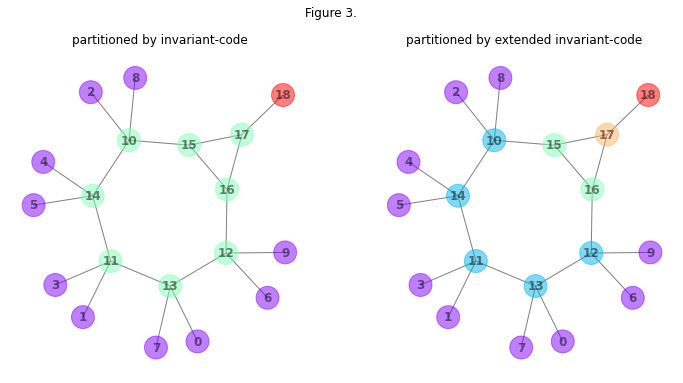

In [4]:
m_partitioned_by_extended_invariants = partition_molecule_by_attribute(m, "invariant_code", include_neighbors=True)
print_molecule(m_partitioned_by_extended_invariants, f"Table 2. {molecule.capitalize()} partitioned by extended invariant-code.")
draw_molecules([m_partitioned_by_invariants, m_partitioned_by_extended_invariants],
               ["partitioned by invariant-code", "partitioned by extended invariant-code"],
               highlight="partition", title="Figure 3.")

When we have a look at nodes `0` through `9` from partition `0` in `Table 2`, we notice that $\{0, 1, 3, 4, 5, 7\}$ are connected to neighbors from partition `1`, whereas $\{2, 6, 8, 9\}$ are connected to neighbors from partition `2`.

| label | invariant-code | partition | neighbors (label, invariant-code, partition) |
|---|---|---|---|
| 0 | 1-0 | 0 | (11, 6-1,0, 1) |
| 1 | 1-0 | 0 | (10, 6-1,0, 1) |
| 2 | 1-0 | 0 | (13, 6-1,0, 2) |
| 3 | 1-0 | 0 | (10, 6-1,0, 1) |
| 4 | 1-0 | 0 | (12, 6-1,0, 1) |
| 5 | 1-0 | 0 | (12, 6-1,0, 1) |
| 6 | 1-0 | 0 | (14, 6-1,0, 2) |
| 7 | 1-0 | 0 | (11, 6-1,0, 1) |
| 8 | 1-0 | 0 | (13, 6-1,0, 2) |
| 9 | 1-0 | 0 | (14, 6-1,0, 2) |

This means that we can further discriminate the nodes in partition `0` based on the partitions of their neighbors.
In other words, we can refine the partitions recursively ("partitioning by partition").
In `Figure 4` we show what happens if we repeat the recursive partitioning until the number of partitions doesn't change anymore:
throughout two rounds of refinement, we go from seven to eight to eventually nine partitions.
Recursive partitioning is conceptually related to _color-refinement_ in the sense of the _Weisfeiler-Leman_ algorithm ([Kiefer, 2020](https://sci-hub.ru/https://doi.org/10.1145/3436980.3436982); [Bieber, 2019](https://www.davidbieber.com/post/2019-05-10-weisfeiler-lehman-isomorphism-test/)), which is known in chemistry as the _Morgan_ algorithm ([Morgan, 1965](https://sci-hub.ru/https://doi.org/10.1021/c160017a018)).


refinement iteration 1
label    invariant-code    partition    neighbors (label, invariant-code, partition)
-------  ----------------  -----------  ----------------------------------------------
0        1                 0            (11, 6, 1)
1        1                 0            (10, 6, 1)
2        1                 0            (13, 6, 2)
3        1                 0            (10, 6, 1)
4        1                 0            (12, 6, 1)
5        1                 0            (12, 6, 1)
6        1                 0            (14, 6, 2)
7        1                 0            (11, 6, 1)
8        1                 0            (13, 6, 2)
9        1                 0            (14, 6, 2)
10       6                 1            (12, 6, 1), (11, 6, 1), (1, 1, 0), (3, 1, 0)
11       6                 1            (10, 6, 1), (14, 6, 2), (0, 1, 0), (7, 1, 0)
12       6                 1            (13, 6, 2), (10, 6, 1), (4, 1, 0), (5, 1, 0)
13       6                 2            

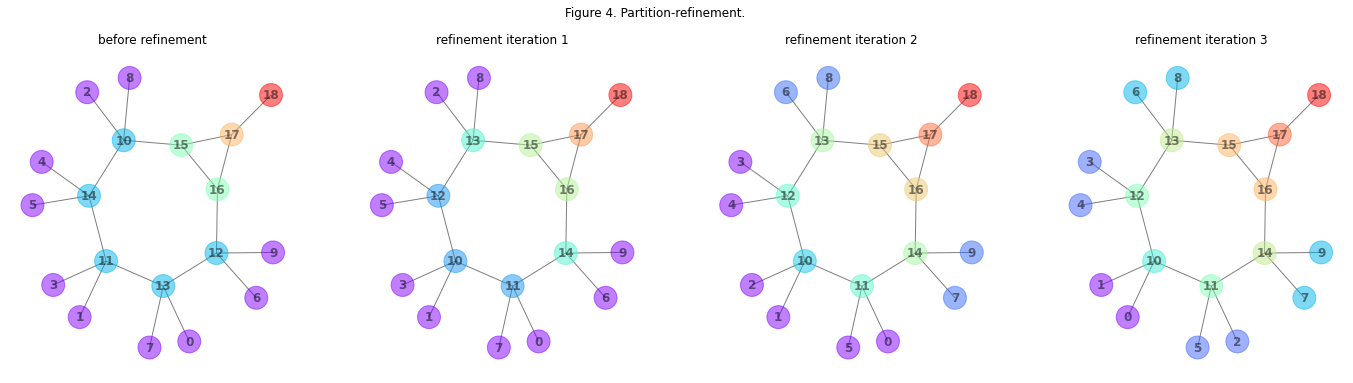

In [5]:
refinements = list(refine_partitions(m_partitioned_by_extended_invariants))
draw_molecules([m_partitioned_by_extended_invariants] + refinements,
               ["before refinement"] + [f"refinement iteration {i + 1}" for i in range(len(refinements))],
               highlight="partition", title="Figure 4. Partition-refinement.")
for i, m_partitioned in enumerate(refinements):
    print_molecule(m_partitioned, f"refinement iteration {i + 1}")

After the refinement of the partitions, no partition contains more than two nodes.
This brings us closer to the goal of the canonicalization, that is, we are closer to shattering the molecule such that each node resides in a unique partition.
We hope to demonstrate in the following that for many molecules, in order to canonicalize them, it's not necessary to permute all automorphism groups as discussed earlier in "Molecule partitioning based on node-invariants".
We show that many partitions can be canonicalized without permutation once we're able to traverse the graph in a deterministic manner.

## Molecule traversal
We can traverse a graphs' nodes in a deterministic manner if we can establishing branching priorities.
More concretely, we need a principle by which we can decide which node to branch to (i.e., "where to go") in situations where the traversal can branch to multiple neighbors from node $i$.
We can use the partitions to establish the following branching priorities.
Starting at node `0`, we traverse the graph in [breadth-first-search-order](https://en.wikipedia.org/wiki/Breadth-first_search), while adhering to the following branching priorities:

At node $i$ from partition $P$, branch to the smallest-labeled neighbor from...
1. ... smaller partition than $i$
2. ... greater partition than $i$
3. ... same partition as $i$

Note that the order of the priorities isn't relevant as long as it's applied consistently (throughout the canonicalization of graphs that are meant to be compared based on their canonicalization).

In order to canonicalize the graph during the traversal, we swap the labels such that $i$ gets assigned the smallest-available label $j$ that remains in $P$ (once assigned, $j$ is removed from $P$).

Below we illustrate the first ten steps of the traversal and show the result of the canonicalization in `Figure 5`. 
$i(P)$ denotes node $i$ from partition $P$.
$i(P):j$ means "swap node $i$ from partition $P$ against node $j$" (note that swaps only happen within the same partition).
```
            0(0)
            │
            │1
            │
            ▼
┌──────────10(3)──────────────────────┐
│           │                         │
│2          │3                        │4
│           │                         │
▼           ▼                         ▼
1(0)  ┌────11(4)─────┐        ┌──────12(4)─────┐
      │     │        │        │       │        │
      │5    │6       │7       │8      │9       │10
      │     │        │        │       │        │
      ▼     ▼        ▼        ▼       ▼        ▼
      2(1)  5(1):3  14(5):13  3(1):4  4(1):5  13(5):14
                     │                         │
                     │                         │
                     │                         │
                     ▼                         ▼
                    ...                       ...
```

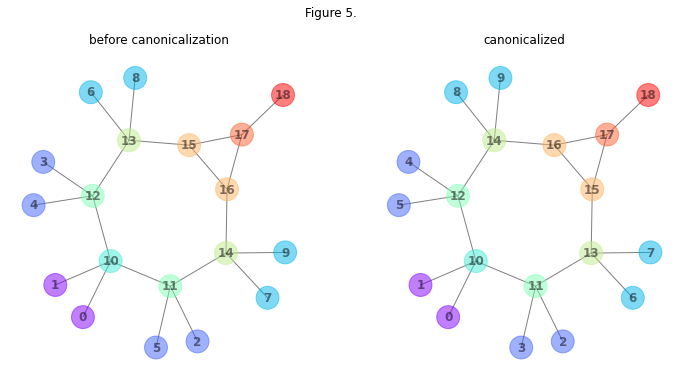

In [6]:
canonical_idcs = assign_canonical_labels(m_partitioned, 0)
m_canonicalized = nx.relabel_nodes(m_partitioned, canonical_idcs, copy=True)
draw_molecules([m_partitioned, m_canonicalized], ["before canonicalization", "canonicalized"],
               highlight="partition", title="Figure 5.")

Branching deterministically by partition doesn't work in situations where we can branch to multiple nodes that are part of the _same_ partition.
Consider for example node `15` in `Figure 5`.
From there (coming from node `18`) we can only branch to nodes `16` and `17`, which belong to the same partition.
We cannot determine where to branch.
Note that this doesn't matter if we can be sure that nodes `16` and `17` are automorphic (which, in this case, based on visual inspection, we can).
However, since in the general case, we cannot guarantee that atoms from one partition are automorphic (see "Molecule partitioning based on node-invariants" above), we need to exhaustively permute those partitions that contain any node to which we cannot branch deterministically.
Partitions that exclusively contain terminal nodes (i.e., nodes with one edge) are an exception, since their members are always automorphic.

Even though some of the partitions might still need to be permuted, our approach can drastically reduce the computational costs of the canonicalization by substantially decreasing the number of partitions that need to be permuted.
In the worst case, we cannot branch deterministically from _any_ node.
For a graph with $N$ nodes and $k$ partitions (containing $n_k$ nodes), that means we need to perform $\prod_{i=1}^{k}n_i!$ permutations.
However, with our approach we can often reduce $k$ by $d$, the number of partitions that exclusively contain nodes to which we can branch deterministically.
Often, $d=k$, meaning that no permutation is necessary at all (i.e., $k=0$), as we can see below.
In our test set, $d=k$ was the case for about half of the graphs.
For the remaining half, $d$ was a substantial fraction of $k$.

1: Couldn't branch determinstically to 2/34 partition(s): {16, 17}.
2: Couldn't branch determinstically to 2/11 partition(s): {6, 7}.
3: Couldn't branch determinstically to 1/25 partition(s): {16}.
4: Couldn't branch determinstically to 1/11 partition(s): {7}.
5: Couldn't branch determinstically to 2/22 partition(s): {16, 15}.
6: Couldn't branch determinstically to 1/4 partition(s): {2}.
7: Couldn't branch determinstically to 1/22 partition(s): {12}.
8: Couldn't branch determinstically to 1/115 partition(s): {55}.
9: Couldn't branch determinstically to 1/115 partition(s): {55}.
10: Couldn't branch determinstically to 2/13 partition(s): {9, 10}.
11: Couldn't branch determinstically to 1/9 partition(s): {6}.
12: Couldn't branch determinstically to 3/30 partition(s): {13, 14, 15}.
13: Couldn't branch determinstically to 2/23 partition(s): {22, 15}.
14: Couldn't branch determinstically to 1/24 partition(s): {21}.
15: Couldn't branch determinstically to 2/22 partition(s): {19, 13}.
16: Coul

/workspaces/tucan/tucan/visualization.py:88: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(n_molecules * 6, 6))


116: Couldn't branch determinstically to 1/20 partition(s): {18}.
117: Couldn't branch determinstically to 2/12 partition(s): {10, 5}.
118: Couldn't branch determinstically to 2/44 partition(s): {16, 18}.
119: Couldn't branch determinstically to 3/15 partition(s): {8, 10, 14}.
120: Couldn't branch determinstically to 2/17 partition(s): {16, 9}.
121: Couldn't branch determinstically to 1/43 partition(s): {22}.
122: Couldn't branch determinstically to 2/16 partition(s): {13, 15}.
123: Couldn't branch determinstically to 1/12 partition(s): {11}.

Couldn't deterministically traverse 123 out of 197 molecules (showing only molecules with <= 15 nodes):


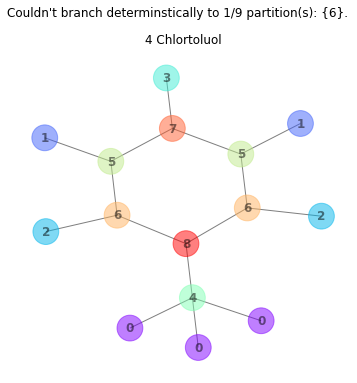

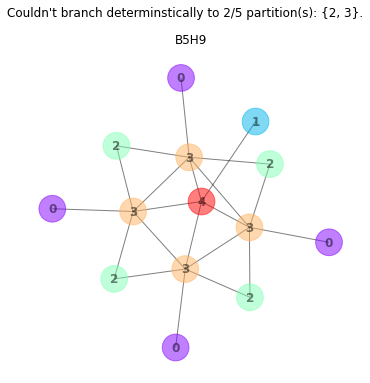

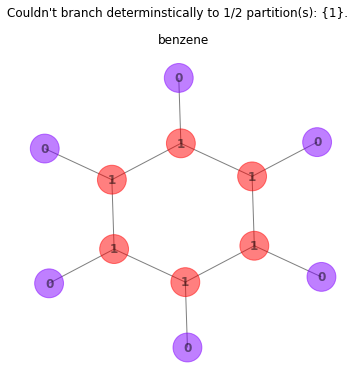

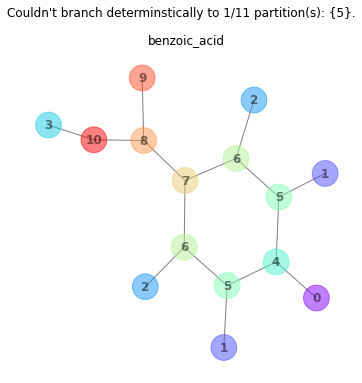

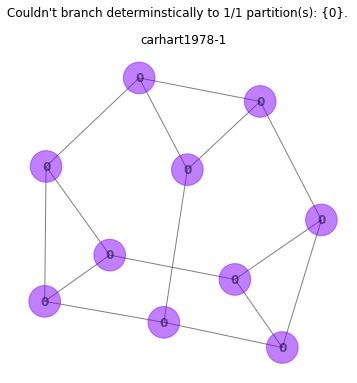

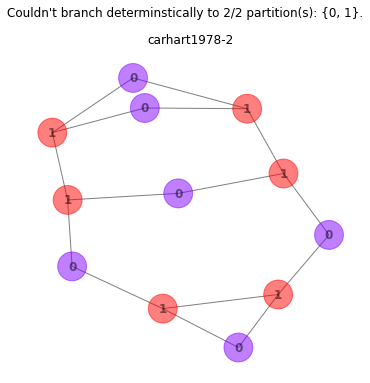

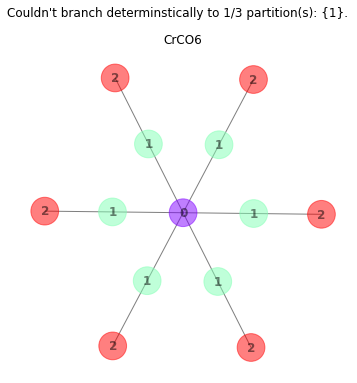

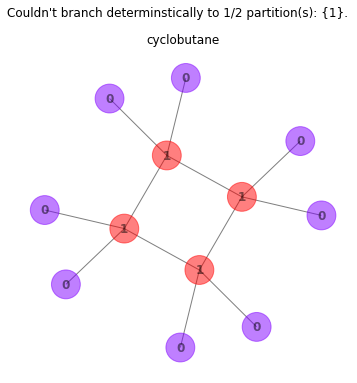

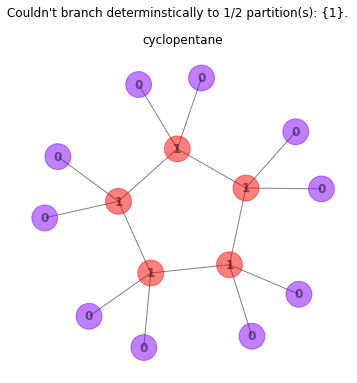

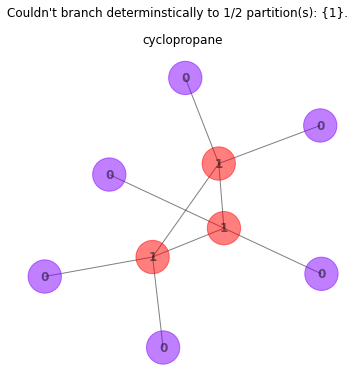

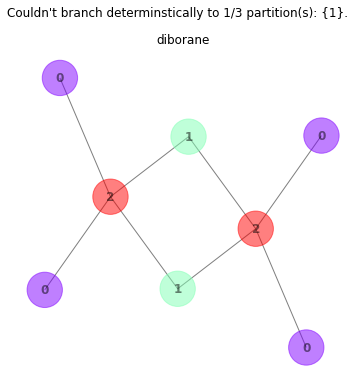

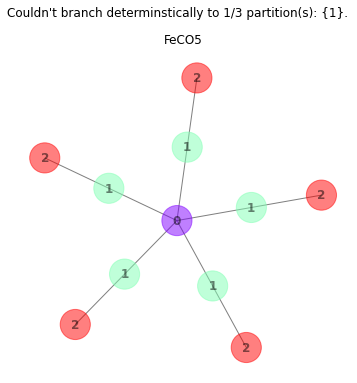

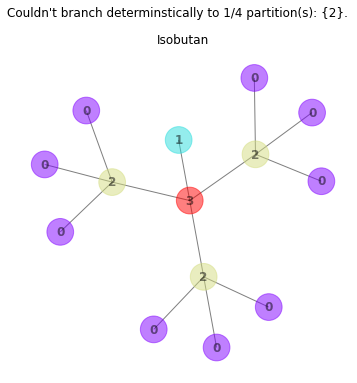

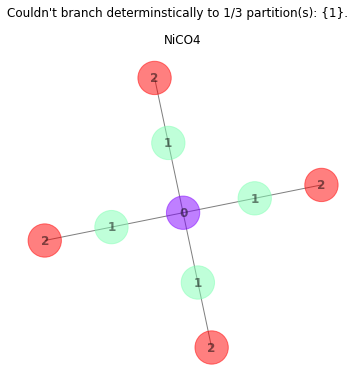

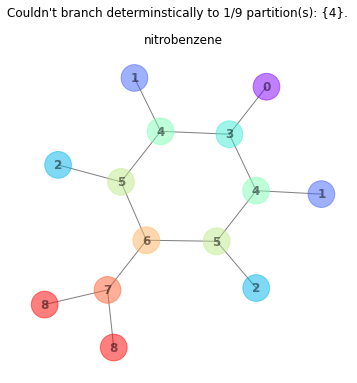

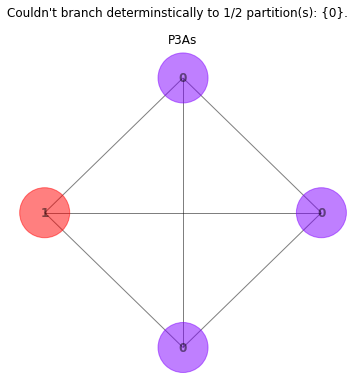

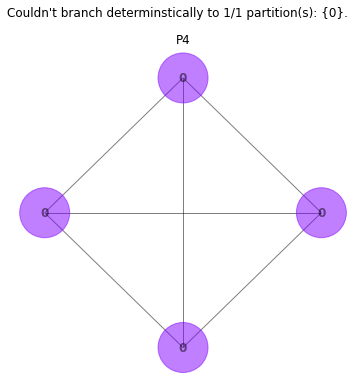

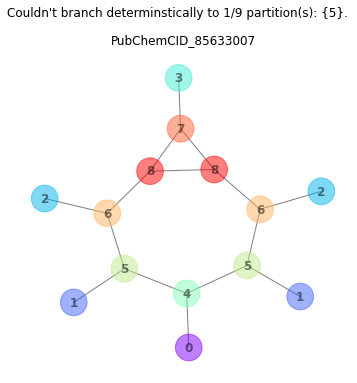

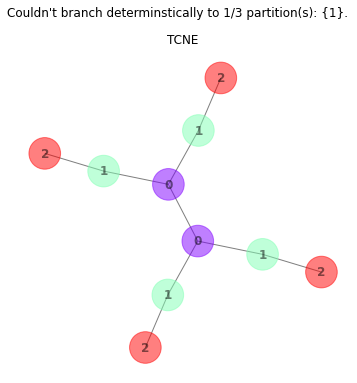

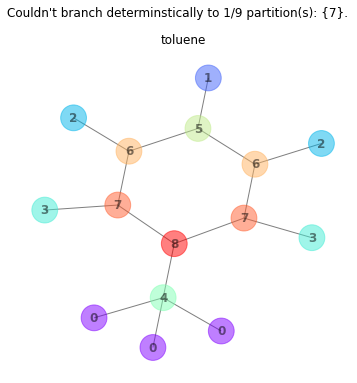

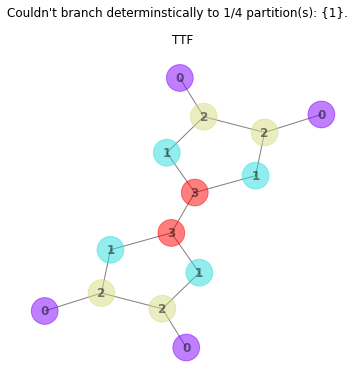

In [7]:
testfiles = list(Path("../tests/molfiles").glob("*/*.mol"))
n_permutation_necessary = 0
for f in testfiles:
    m = graph_from_file(f)
    m_partitioned = partition_molecule_by_attribute(m, "invariant_code", include_neighbors=True)
    m_refined = list(refine_partitions(m_partitioned))
    m_partitioned = m_refined[-1] if m_refined else m_partitioned
    try:
        canonical_idcs = assign_canonical_labels(m_partitioned, 0, enforce_deterministic_branching=True)
    except AssertionError as e:
        n_permutation_necessary += 1
        print(f"{n_permutation_necessary}: {e}")
        if m_partitioned.number_of_nodes() <= 15:
            draw_molecules([m_partitioned], [f.stem],
                           labels=dict(m_partitioned.nodes.data("partition")),
                           highlight="partition", title=str(e))
        
print(f"\nCouldn't deterministically traverse {n_permutation_necessary} out of {len(testfiles)} molecules (showing only molecules with <= 15 nodes):")

Note that in the examples above, we _could_ continue traversing, since we can confirm visually that all partitions are automorphic. Nevertheless, we need to stop the traversal as soon as we encounter a node from where we cannot branch deterministically, since there's no _guarantee_ in the general case that the partition we're about to branch to is automorphic.

Moreover, the canonical labeling depends on where the traversal starts (root node).
Below we once start traversing terephthalic acid from node `0` (partition `0`), and once we start from node `4` (partition `1`).
Note the resulting discrepancy in canonical labeling.
However, as long as we consistently start the traversal from a specific node, the canonical labeling is invariant.

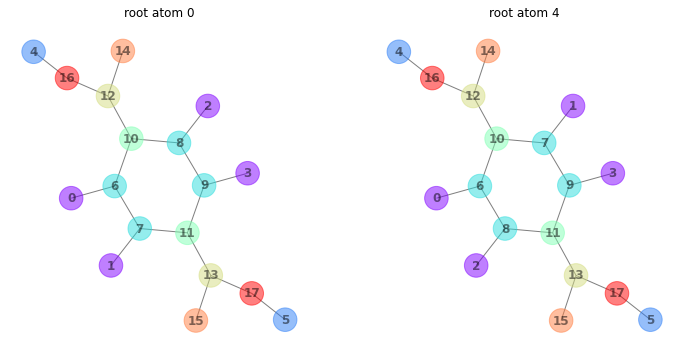

In [8]:
m = graph_from_file(construct_filepath("terephthalic_acid"))
m_partitioned = partition_molecule_by_attribute(m, "invariant_code", include_neighbors=True)
m_refined = list(refine_partitions(m_partitioned))
m_partitioned = m_refined[-1] if m_refined else m_partitioned
canonical_labels_0 = assign_canonical_labels(m_partitioned, 0)
canonical_labels_4 = assign_canonical_labels(m_partitioned, 4) 
draw_molecules([nx.relabel_nodes(m_partitioned, canonical_labels_0, copy=True),
                nx.relabel_nodes(m_partitioned, canonical_labels_4, copy=True)],
               ["root atom 0", "root atom 4"], highlight="partition")

# Serialization
The serialization should result in a string representation of the molecule, which (i.e., the string representation) should allow both humans and machines to reconstruct the molecule's topology (i.e., the molecular graph). Our string representation consists of the sum formula (arranged according to the [Hill system](https://en.wikipedia.org/wiki/Chemical_formula#Hill_system)), followed by a sequence of 2-tuples. Each tuple represents the labels of two connected nodes.

In [9]:
print(serialize_molecule(m_canonicalized))

C8H10O/1-11/2-11/3-12/4-12/5-13/6-13/7-14/8-14/9-15/10-15/11-12/11-13/12-14/13-15/14-16/15-17/16-17/16-18/17-18/18-19


In order to be able to reconstruct the molecule based on this representation, we organize the tuples such that increasing node labels pertain to nodes with increasing atomic number. This means that we can infer the atomic number associated with a node label from the sum formula. For example, the sum formula above indicates that the molecule consists of ten hydrogens, eight carbons, and one oxygen. Since increasing labels pertain to nodes with increasing atomic numbers, we can infer that the labels `1` through `10` pertain to hydrogens, whereas labels `11` through `18` refer to carbons, and finally, label `19` refers to the oxygen.

Below we show a selection of those molecules that cannot be canonicalized with the current invariant(s).

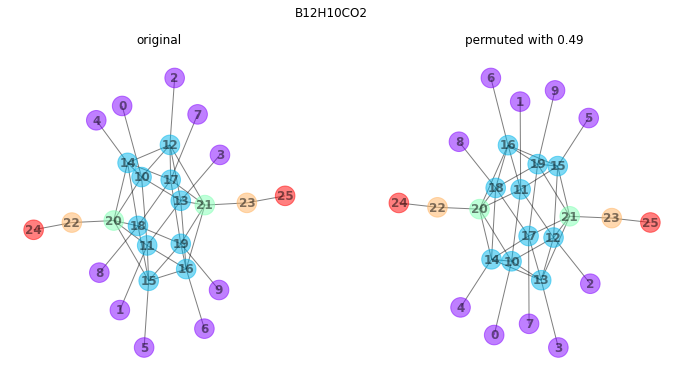

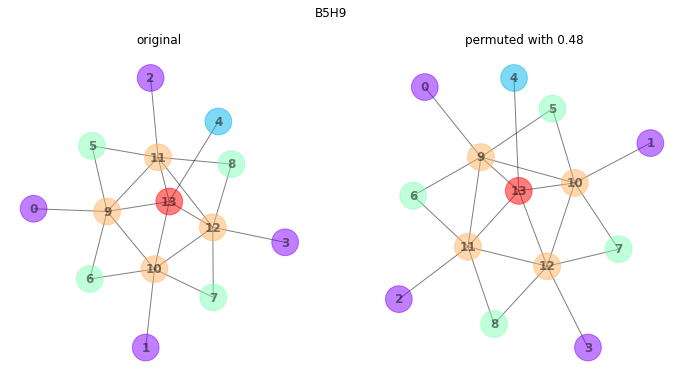

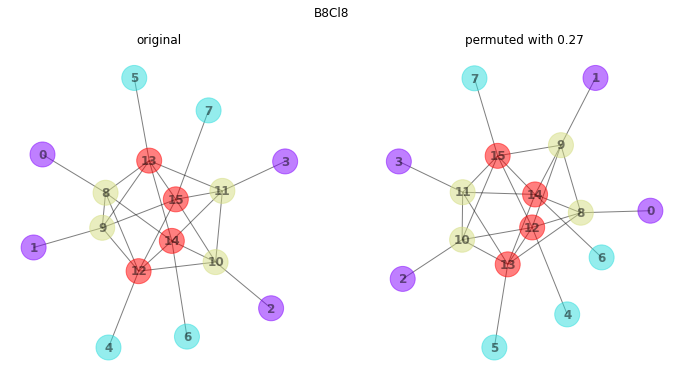

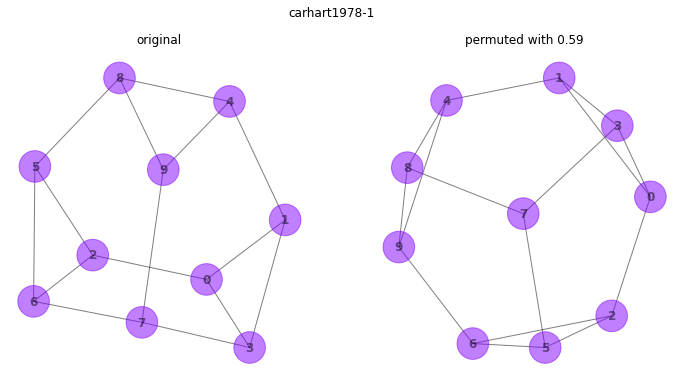

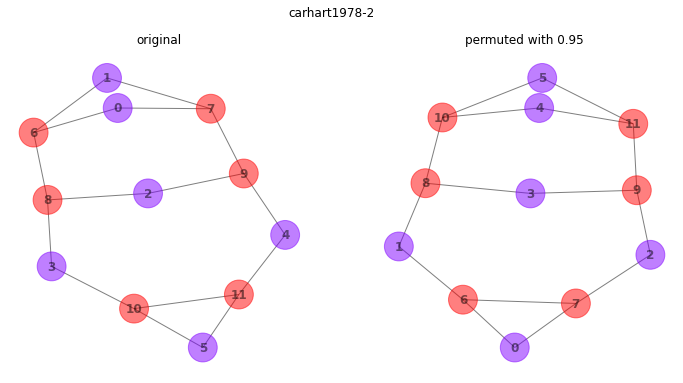

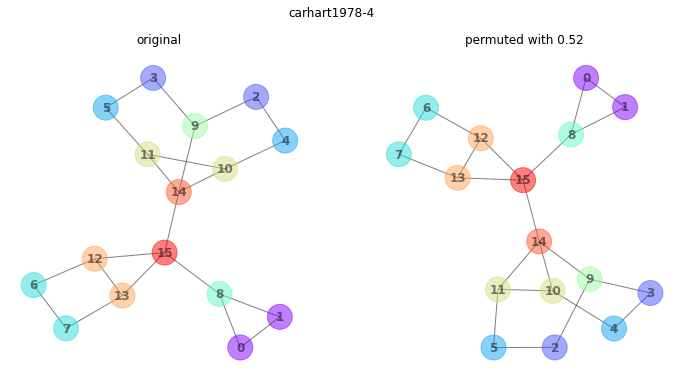

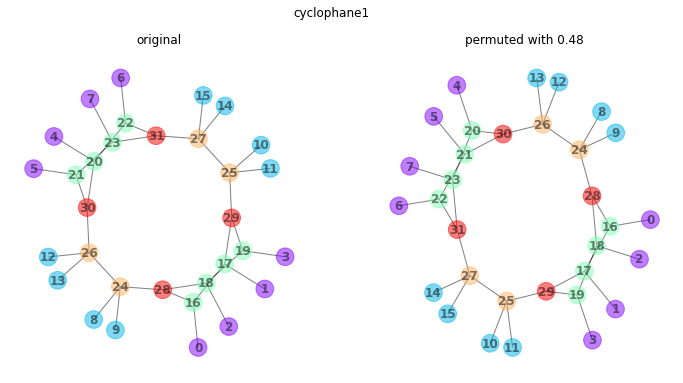

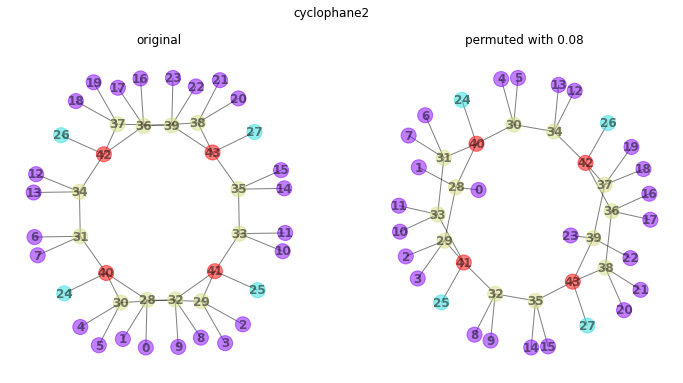

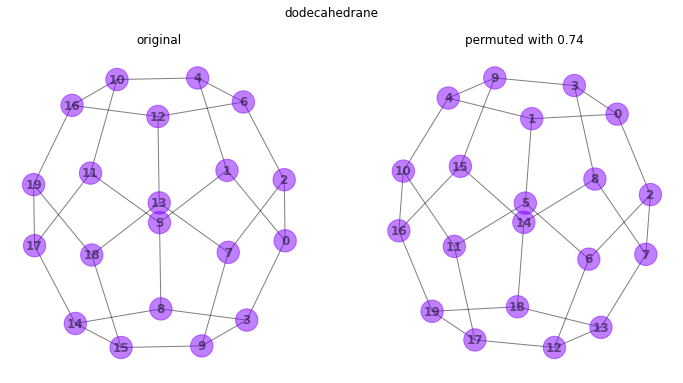

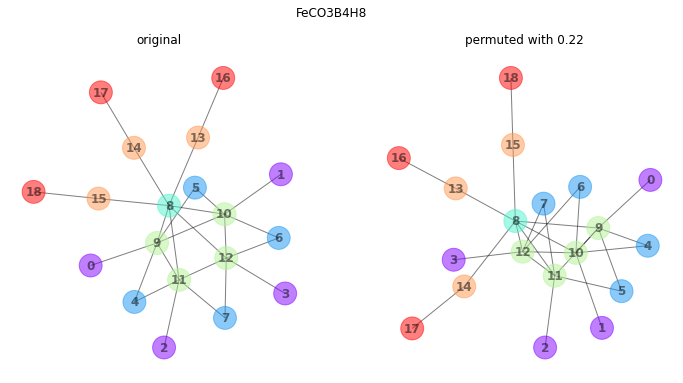

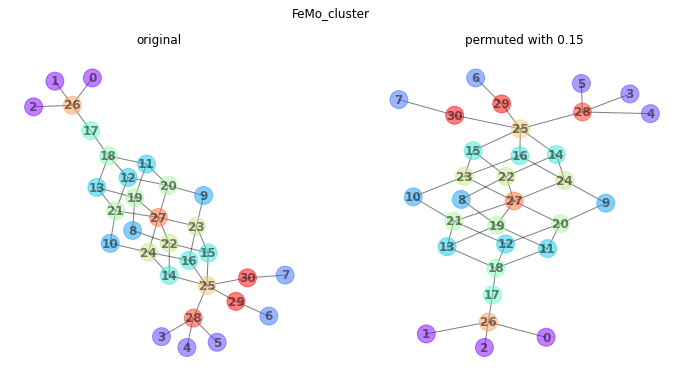

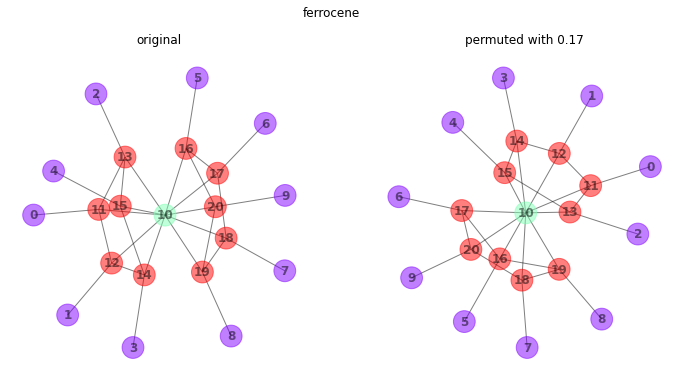

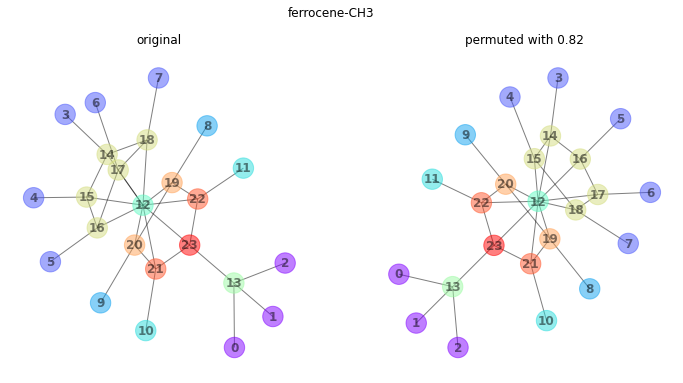

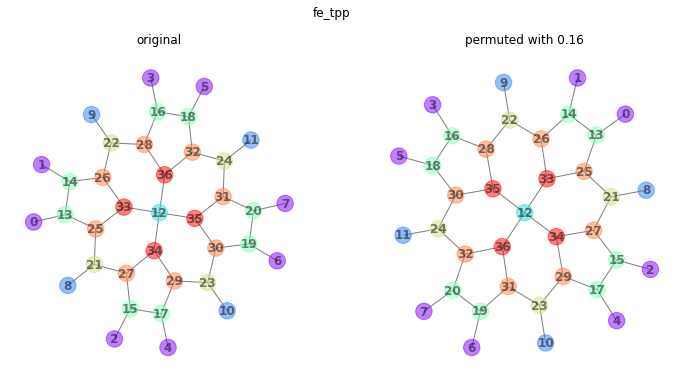

In [10]:
testfiles = list(Path("../tests/molfiles").glob("*/*.mol"))
root_atom = 0
random.seed(.42)
for f in testfiles:
    m = graph_from_file(f)
    if m.number_of_nodes() > 50 or not is_connected(m):
        continue
    m_canon = canonicalize_molecule(m, root_atom)
    m_serialized = serialize_molecule(m_canon)
    for _ in range(10):
        permutation_seed = round(random.random(), 2)
        m_permu = permute_molecule(m, random_seed=permutation_seed)
        m_permu_canon = canonicalize_molecule(m_permu, root_atom)
        m_permu_serialized = serialize_molecule(m_permu_canon)
        if m_serialized != m_permu_serialized:
            draw_molecules([m_canon, m_permu_canon],
                           ["original", f"permuted with {permutation_seed}"],
                           highlight="partition", title=f.stem)
            break


In [12]:
name = "Carhart1978-1"
m = graph_from_file(construct_filepath(name))
m_canon = canonicalize_molecule(m, 0)
m_permu = permute_molecule(m, random_seed=0.48)
m_permu_canon = canonicalize_molecule(m_permu, 0)
draw_molecules([m_canon, m_permu_canon],
                ["original", "permuted"],
                highlight="partition", title=f.stem, dim=3)